![logo](./img/LogoLine_horizon_C3S.png)

<br>

# Analysis of Projected versus Historical Climatology with CORDEX Data

## About

This notebook is a practical introduction to [CORDEX regional climate model data on single levels](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cordex-domains-single-levels?tab=overview). CORDEX data are available for 14 regional domains and variable spatial resolutions, from 0.11 x 0.11 degrees up to 0.44 x 0.44 degrees. This workflow will demonstrate how to compute the difference in the air temperature climatology for 2071-2100 (according to a projected scenario) relative to the reference period 1971-2000 in Africa, with a spatial resolution of 0.44 x 0.44 degrees. 

We will use the historical experiment to compute the past climatology and repeat the steps to compute the projected climatology according to the scenario RCP4.5. Finally, we will take the difference between the two in order to assess the extent of change. This is called the "delta method" which takes the climate change signal as the difference between the future and past considering that the model biases are the same and can therefore be removed with the subtraction.

This particular example uses data from the Canadian Regional Climate Model `CCCma_CanRCM4`, with lateral boundary conditions from the Global Climate Model (GCM) `CanESM2`, also Canadian. This coupled model is referred to as `CanRCM4 - CanESM2`. See [here](https://confluence.ecmwf.int/display/CKB/CORDEX%3A+Regional+climate+projections#CORDEX:Regionalclimateprojections-DrivingGlobalClimateModelsandRegionalClimateModels) a full list of models included in the CDS-CORDEX subset.

**Note:** The workflow uses a specific model, scenario and geographical area, but you can use any model, scenario or domain, and indeed any period or variable. To have a more accurate idea of projected climate change, it is typical to calculate an ensemble of multiple models. Only for the sake of simplicity do we focus on one model.

<br>

In general, CORDEX experiments can be divided into three main categories:

* **Evaluation**: model simulations for the past with imposed "perfect" lateral boundary conditions following ERA-Interim reanalysis (1979-2015).

* **Historical**: Historical experiments cover the period where modern climate observations exist. These experiements show how the RCMs perform for the past climate when forced by the Global Circulation Model (GCM) and can be used as a reference period for comparison with scenario runs for the future. 

* **Scenario experiments RCP2.6, RCP4.5, RCP8.5**: ensemble of CORDEX climate projection experiments driven by boundary conditions from GCMs using RCP (Representative Concentration Pathways) forcing scenarios. The scenarios used here are RCP 2.6, 4.5 and 8.5, which provide different pathways of the future climate forcing.

Learn [here](https://confluence.ecmwf.int/display/CKB/CORDEX%3A+Regional+climate+projections#CORDEX:Regionalclimateprojections-Experiments) more about CORDEX experiments in the Copernicus Climate Data Store (CDS).


The notebook has the following outline:
1. Request data from the CDS programmatically with the CDS API
2. Unzip the downloaded data files
3. Compute CORDEX historical climatology for reference period 1971-2000
4. Compute CORDEX projected climatology for target period 2071-2100 based on scenario RCP4.5
5. Compute and visualize the climate change signal

## Data

This notebook introduces you to [CORDEX regional climate model data on single levels](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cordex-domains-single-levels?tab=overview). The data used in the notebook has the following specifications:

> **Data**: `CORDEX regional climate model data on single levels - Experiment: Historical` <br>
> **Temporal coverage**: `1 Jan 1971 to 31 Dec 2000` <br>
> **Spatial coverage**: `Domain: Africa` <br>
> **Format**: `NetCDF in zip archives`


> **Data**: `CORDEX regional climate model data on single levels - Experiment: RCP4.5` <br>
> **Temporal coverage**: `1 Jan 2071 to 31 Dec 2100` <br>
> **Spatial coverage**: `Domain: Africa` <br>
> **Format**: `NetCDF in zip archives`
<br>


<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-c3s/main?labpath=projections-cordex.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training-c3s/blob/main/projections-cordex.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/copernicus-training-c3s/blob/main/projections-cordex.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

<hr>

### Install CDS API via pip

In [1]:
!pip install cdsapi

### Load libraries

In [2]:
# CDS API
import cdsapi

# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

# Other libraries (e.g. paths, filenames, zipfile extraction)
from glob import glob
from pathlib import Path
from os.path import basename
import zipfile
import urllib3 
urllib3.disable_warnings() # Disable "InsecureRequestWarning" 
                           # for data download via API

<hr>

## Request data from the CDS programmatically with the CDS API

The first step is to request data from the Climate Data Store programmatically with the help of the CDS API. Let us make use of the option to manually set the CDS API credentials. First, you have to define two variables: `URL` and `KEY` which build together your CDS API key. Below, you have to replace the `#########` with your personal CDS key. Please find [here](https://cds.climate.copernicus.eu/api-how-to) your personal CDS key.

In [19]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = '##########'

In [4]:
DATADIR = './'

The next step is then to request the data with the help of the CDS API. Below are two blocks of code for the following data requests:
* **Historical experiment**: Daily aggregated historical 2m air temperature (from the CanRCM4 - CanESM2 model) from 1971 to 2000 for Africa.
* **RCP4.5 experiment**: Daily aggregated RCP4.5 projections of 2m air temperature (from the CanRCM4 - CanESM2 model) from 2071 to 2100 for Africa

> **Note:** Before you run the cells below, the terms and conditions on the use of the data need to have been accepted in the CDS. You can view and accept these conditions by logging into the [CDS](http://cds.climate.copernicus.eu), searching for the dataset, then scrolling to the end of the *Download data* section.

In [ ]:
c = cdsapi.Client(url=URL, key=KEY)

c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        'format': 'zip',
        'domain': 'africa',
        'experiment': 'historical',
        'horizontal_resolution': '0_44_degree_x_0_44_degree',
        'temporal_resolution': 'daily_mean',
        'variable': '2m_air_temperature',
        'gcm_model': 'cccma_canesm2',
        'rcm_model': 'cccma_canrcm4',
        'ensemble_member': 'r1i1p1',
        'start_year': ['1971', '1976', '1981', '1986', '1991', '1996'],
        'end_year': ['1975', '1980', '1985', '1990', '1995', '2000'],
    },
    f'{DATADIR}1971-2000_cordex_historical_africa.zip')

2024-04-10 13:40:06,401 INFO Welcome to the CDS
2024-04-10 13:40:06,402 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cordex-domains-single-levels
2024-04-10 13:40:06,799 INFO Request is queued
2024-04-10 13:40:07,931 INFO Request is running
2024-04-10 13:50:26,550 INFO Request is completed
2024-04-10 13:50:26,551 INFO Downloading https://download-0007-clone.copernicus-climate.eu/cache-compute-0007/cache/data6/dataset-projections-cordex-domains-single-levels-54aecd42-9e6d-499e-ba16-55fee0aa53a0.zip to ./1971-2000_cordex_historical_africa.zip (908.2M)
 66%|██████████████████████████▍             | 600M/908M [05:15<02:26, 2.20MB/s]

In [ ]:
c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        'format': 'zip',
        'domain': 'africa',
        'experiment': 'rcp_4_5',
        'horizontal_resolution': '0_44_degree_x_0_44_degree',
        'temporal_resolution': 'daily_mean',
        'variable': '2m_air_temperature',
        'gcm_model': 'cccma_canesm2',
        'rcm_model': 'cccma_canrcm4',
        'ensemble_member': 'r1i1p1',
        'start_year': ['2071', '2076', '2081', '2086', '2091', '2096'],
        'end_year': ['2075', '2080', '2085', '2090', '2095', '2100'],
    },
    f'{DATADIR}2071-2100_cordex_rcp_4_5_africa.zip')

## Unzip the downloaded data files

From the Copernicus Climate Data Store, CORDEX data are available in `NetCDF` format in compressed archives, either `zip` or `tar.gz`. For this reason, before we can load any data, we have to unzip or untar the files. Having downloaded the two experiments `historical` and `RCP4.5` as seperate zip files, we can use the functions from the `zipfile` Python package to extract the content of a zip file. First, we construct a `ZipFile()` object and second, we apply the function `extractall()` to extract the content of the zip file.

Below, the same process is repeated for the two zip files downloaded. We see that the actual data files are disseminated in `NetCDF`. CORDEX files are generally organised in five year periods. For this reason, for each zip file, six `NetCDF` files in five year periods are extracted.

In [5]:
cordex_zip_paths = glob(f'{DATADIR}*.zip')

In [6]:
for j in cordex_zip_paths:
    with zipfile.ZipFile(j, 'r') as zip_ref:
        zip_ref.extractall(f'{DATADIR}')

## Compute CORDEX historical climatology for reference period 1971-2000

The first step is to load the data of the `historical` experiment.

We can use the Python library [xarray](http://xarray.pydata.org/en/stable/) and its function `open_mfdataset` to read and concatenate multiple NetCDF files at once.

The result is a `xarray.Dataset` object with four dimensions: `bnds`, `rlat`, `rlon`, `time`, of which the dimension `bnds` is not callable.

In [7]:
ds_1971_2000_historical = xr.open_mfdataset(f'{DATADIR}*CanESM2_historical*.nc')
ds_1971_2000_historical

<xarray.Dataset>
Dimensions:       (time: 10950, rlon: 194, rlat: 201, bnds: 2)
Coordinates:
  * time          (time) object 1971-01-01 12:00:00 ... 2000-12-31 12:00:00
  * rlon          (rlon) float64 -24.64 -24.2 -23.76 -23.32 ... 59.4 59.84 60.28
  * rlat          (rlat) float64 -45.76 -45.32 -44.88 ... 41.36 41.8 42.24
    lon           (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    lat           (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    height        float64 2.0
Dimensions without coordinates: bnds
Data variables:
    rotated_pole  (time) |S1 b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b'' b''
    tas           (time, rlat, rlon) float32 dask.array<chunksize=(1825, 201, 194), meta=np.ndarray>
    time_bnds     (time, bnds) object dask.array<chunksize=(1825, 2), meta=np.ndarray>
Attributes: (12/26)
    title:                          CanRCM4 model output prepared for CORDEX ...
    institution:                    CCCma (Canadian Centre for Climate Modell...
    institute_id:                   CCCma
    contact:                        cccma_info@ec.gc.ca
    Conventions:                    CF-1.4
    experiment:                     Historical run driven by CCCma-CanESM2
    ...                             ...
    history:                        created: 2012-06-29 23:52:08 by rcm2nc
    data_licence:                   1) GRANT OF LICENCE - The Government of C...
    creation_date:                  2012-06-29-T23:47:03Z
    c3s_comment:                    This data has been published at ESGF with...
    tracking_id:                    hdl:21.14103/3d35a8d3-105d-451c-88fa-4d46...
    c3s_disclaimer:                 This data has been curated and prepared i...

The next step is to load the data variable `tas` from the Dataset above. We can load data variables by adding the name of the variable (`tas`) in square brackets. The resulting object is a `xarray.DataArray`, which offers additional metadata information about the data, e.g. the `unit` or `long_name` of the variable.

In [8]:
tas_1971_2000_historical = ds_1971_2000_historical['tas']
tas_1971_2000_historical

<xarray.DataArray 'tas' (time: 10950, rlat: 201, rlon: 194)>
dask.array<concatenate, shape=(10950, 201, 194), dtype=float32, chunksize=(1825, 201, 194), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1971-01-01 12:00:00 ... 2000-12-31 12:00:00
  * rlon     (rlon) float64 -24.64 -24.2 -23.76 -23.32 ... 59.4 59.84 60.28
  * rlat     (rlat) float64 -45.76 -45.32 -44.88 -44.44 ... 41.36 41.8 42.24
    lon      (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    lat      (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    height   float64 2.0
Attributes:
    long_name:      Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K
    grid_mapping:   rotated_pole
    cell_methods:   time: mean

We will now compute the monthly climatology for the reference period. The monthly climatology represents for each month, and each grid point, the average value over the reference period of 30 years, from 1971 to 2000. We can compute the climatology for each grid point with xarray in two steps: first, all the values for one specific month have to be grouped with the function `groupby()` and second, we can create the average of each group with the function `mean()`.

The result is a three-dimensional DataArray with the dimensions `month`, `rlat` and `rlon`. The operation has changed the name of the `time` dimension to `month`, which has the average near-surface air temperature for each month. Please note that this operation also drops all the attributes (metadata) from the DataArray.

In [9]:
tas_1971_2000_climatology = tas_1971_2000_historical.groupby('time.month').mean()

In a last step, we want to convert the near-surface air temperature values in Kelvin to degrees Celsisus. We can do this by subtracting 273.15 from air temperature values in Kelvin.

In [10]:
tas_1971_2000_climatology_degC = tas_1971_2000_climatology - 273.15

## Compute CORDEX future climatology for target period 2071-2100 based on scenario RCP4.5

Let us now repeat the steps executed for the historical experiment data with the `scenario RCP4.5` data. With the projection data for the target period 2071 to 2100, we can compute the projected climatology according to this particular scenario, which can be compared with the historical climatology from the reference period.

Again, we begin with the function `open_mfdataset()` to load the multiple `NetCDF` files. The scenario data is also organised into separate files for each 5-year period. These will be concatenated along the `time` dimension.

In [11]:
ds_2071_2100_projection = xr.open_mfdataset(f'{DATADIR}*CanESM2_rcp45*.nc')

Again we load the data variable `tas` from the Dataset above into an `xarray.DataArray` object to facilitate further processing:

In [12]:
tas_2071_2100_projection = ds_2071_2100_projection['tas']

# uncomment the line below before running this cell to view the data characteristics
# tas_2071_2100_projection

Now we will compute the monthly climatology for the target period 2071 to 2100, in the same way as we did for the historical period:

In [13]:
tas_2071_2100_climatology = tas_2071_2100_projection.groupby('time.month').mean()

And finally we convert from degrees Kelvin to Celsius:

In [14]:
tas_2071_2100_climatology_degC = tas_2071_2100_climatology - 273.15

## Compute and visualize the climate change signal between the target (2071-2100) and reference (1971-2000) period

Now, we can compute the difference between the two climatologies. Since both DataArrays have the same structure, we can simply subtract the historical climatology from the projected climatology. The resulting data array has the projected averaged temperature difference for each month.

In [15]:
tas_difference_climatology = tas_2071_2100_climatology - tas_1971_2000_climatology

Now, let us visualize the climate change signal between the target (2071-2100) and reference (1971-2000) period for Africa for June. The plotting function below has five main parts:
* **Initiate the plot**: initiate a matplotlib plot with `plt.figure` and `plt.subplot()`
* **Plot the 2D map with pcolormesh**: plot the xarray data array as 2D map with the function pcolormesh
* **Add coast- and gridlines**: add additional items to the plot, such as coast- and gridlines
* **Add title and legend**: Set title and legend of the map
* **Save the figure as png file**

We can change the value for the variable month and we see that the near-surface air temperature difference is for some regions more pronounced for some months, e.g. June, compared to others.

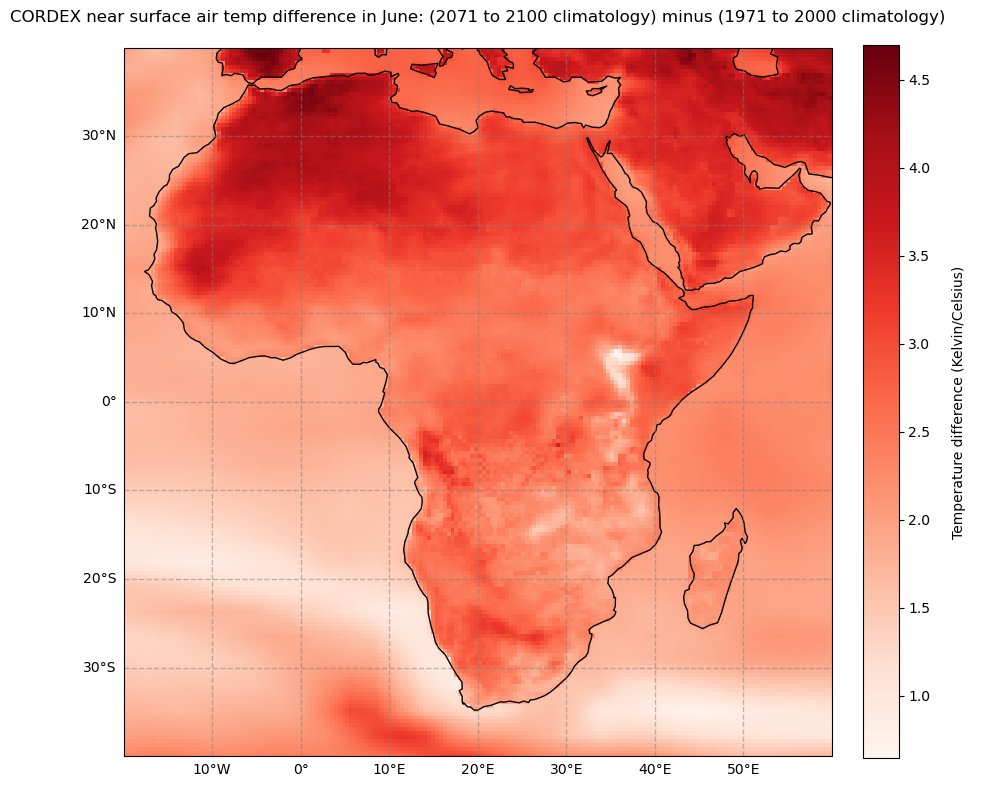

In [16]:
month = 5

# Initiate the plot
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

# Plot the 2D map with pcolormesh
im = plt.pcolormesh(tas_difference_climatology.rlon, tas_difference_climatology.rlat,
                   tas_difference_climatology[month,:,:], cmap='Reds', transform=ccrs.PlateCarree())  # Change colormap to 'Reds'

# Add coast- and gridlines
ax.coastlines(color='black')
ax.set_extent([-20,60,-40,40], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Add title and legend
ax.set_title('CORDEX near surface air temp difference in June: (2071 to 2100 climatology) minus (1971 to 2000 climatology)\n', fontsize=12)
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('\nTemperature difference (Kelvin/Celsius)\n')

# Save the figure
fig.savefig(f'{DATADIR}TAS_1971-2000_2071-2100_june.png', dpi=300)


As a last step, we repeat the visualization of climate change signal between the target (2071-2100) and reference (1971-2000) period. But this time, we create the average signal for the whole period, not only one month. For this, we have to compute the average over all months with the function `mean()`.

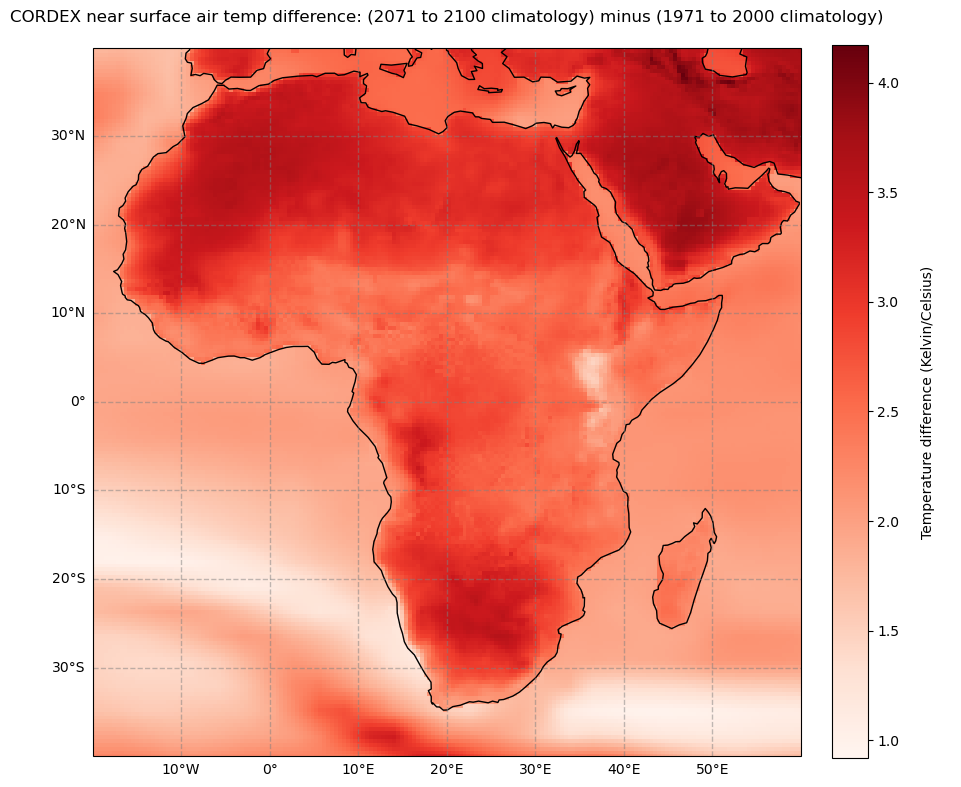

In [18]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

im = plt.pcolormesh(tas_difference_climatology.rlon, tas_difference_climatology.rlat,
                   tas_difference_climatology.mean('month'), cmap='Reds', transform=ccrs.PlateCarree())

ax.coastlines(color='black')
ax.set_extent([-20,60,-40,40], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_title('CORDEX near surface air temp difference: (2071 to 2100 climatology) minus (1971 to 2000 climatology)\n', fontsize=12)

cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('\nTemperature difference (Kelvin/Celsius)\n')

fig.savefig(f'{DATADIR}TAS_1971-2000_2071-2100.png', dpi=300)

<hr>

<p></p>
<span style='float:right'><p style=\"text-align:right;\">This project is licensed under <a href="./LICENSE">APACHE License 2.0</a>. | <a href=\"https://github.com/ecmwf-projects/copernicus-training">View on GitHub</a></span>